### Part 1: Retrieval-Augmented Generation (RAG) Model for QA Bot

Problem Statement:
     
Develop a Retrieval-Augmented Generation (RAG) model for a Question Answering (QA) bot for a business.     
Use a vector database like Pinecone DB and a generative model like Cohere API (or any other available alternative).      
The QA bot should be able to retrieve
relevant information from a dataset and generate coherent answers.

Task Requirements:
1. Implement a RAG-based model that can handle questions related to a provided
document or dataset.
2. Use a vector database (such as Pinecone) to store and retrieve document
embeddings efficiently.
3. Test the model with several queries and show how well it retrieves and generates
accurate answers from the document.   

Deliverables:           
1. A Colab notebook demonstrating the entire pipeline, from data loading to question answering.         
2. Documentation explaining the model architecture, approach to retrieval, and how generative responses are created.      
3. Provide several example queries and the corresponding outputs.

### Assumptions

1. I am assuming that we can have our text data in any document format [txt, pdf, docx, html, etc] hence I am going to impliment a logic to handle any such document.
2. I have used a sample small document [generated by ChatGpt] for the testing purpose of QNA. The content of that document can be found here : https://github.com/Dhiraj223/SimpleRagApplication/blob/main/test.txt

In [1]:
# Get the Document
!curl -o ../data/test.txt https://raw.githubusercontent.com/Dhiraj223/SimpleRagApplication/main/test.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  8489  100  8489    0     0  17433      0 --:--:-- --:--:-- --:--:-- 17947
100  8489  100  8489    0     0  17404      0 --:--:-- --:--:-- --:--:-- 17947


In [2]:
# Importing the Libraries
import os
import docx
import PyPDF2
import cohere
import chardet
import requests
import pytesseract
import pandas as pd
from PIL import Image
from bs4 import BeautifulSoup
from typing import Union, Dict, Any, List, Tuple
from urllib.parse import urlparse
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\jhadh\AppData\Local\sagemaker\sagemaker\config.yaml


c:\Dhiraj\DeepLearning\RAG-SampleSet-QNAChatBot\.venv\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
from dotenv import load_dotenv

load_dotenv('../.env')

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
COHERE_API_KEY = os.getenv("COHERE_API_KEY")

# Document Processing Pipeline

This pipeline allows users to load, split, store, and retrieve documents efficiently using vector embeddings. It also integrates an external API (Cohere) for generating answers based on queries.

---

## 1. `DocumentLoader` Class

### Purpose:
Loads data from various file formats or URLs.

### Attributes:
- **path (str)**: The path to the file or URL.
- **data (str or dict)**: The loaded data.

### Methods:

- **`__init__(self, path: str)`**  
  Initializes the DocumentLoader with the specified file path or URL.

- **`load_data(self) -> Union[str, Dict[str, Any]]`**  
  Loads data from the file based on the extension or from the web if the path is a URL.  
  - **Returns**: String or dictionary (depending on the file format).  
  - **Raises**: `ValueError` for unsupported formats or invalid URLs, `IOError` for reading errors.

- **`_is_url(self, path: str) -> bool`**  
  Checks if the given path is a URL.

- **`_load_web_page(self, url: str) -> str`**  
  Loads text from a web page.  
  - **Raises**: `ValueError` if the web page cannot be loaded.

- **`_load_pdf(self) -> str`**  
  Loads text from a PDF file.

- **`_load_docx(self) -> str`**  
  Loads text from a DOCX file.

- **`_load_html(self) -> str`**  
  Loads text from an HTML file.

- **`_load_txt(self) -> str`**  
  Loads text from a TXT or Markdown file.

- **`_load_csv(self) -> str`**  
  Loads data from a CSV file and returns it as a string.

- **`_load_excel(self) -> str`**  
  Loads data from Excel files and returns it as a string.

- **`_load_image(self) -> str`**  
  Loads text from an image using OCR (Optical Character Recognition).

---

## 2. `DocumentSplitter` Class

### Purpose:
Splits large text data into smaller chunks for easier processing and retrieval.

### Attributes:
- **data (str)**: The input text to be split.
- **chunk_size (int)**: The size of each chunk in characters (default: 1000).
- **overlap (int)**: The number of overlapping characters between chunks (default: 200).

### Methods:

- **`__init__(self, data: str, chunk_size: int = 1000, overlap: int = 200)`**  
  Initializes the DocumentSplitter with the text, chunk size, and overlap.

- **`split_data(self) -> List[str]`**  
  Splits the text into overlapping chunks.  
  - **Returns**: A list of text chunks.

---

## 3. `VectorStore` Class

### Purpose:
Stores, indexes, and retrieves text chunks using vector embeddings for Retrieval-Augmented Generation (RAG).

### Attributes:
- **vectors (List[Tuple[str, ndarray]])**: A list of text chunks and their corresponding vectors.
- **chunks (List[Dict[str, str]])**: A list of the original text chunks.
- **model (SentenceTransformer)**: The sentence transformer model used to generate vector embeddings.

### Methods:

- **`__init__(self, embedding_model_name: str = 'all-MiniLM-L6-v2')`**  
  Initializes the VectorStore with a sentence transformer model (default: `all-MiniLM-L6-v2`).

- **`add_texts(self, chunks: List[Dict[str, str]]) -> None`**  
  Adds text chunks to the vector store by generating embeddings for each chunk.  
  - **Args**:
    - `chunks`: A list of dictionaries containing text chunks.
  
- **`similarity_search(self, index, query: str, k: int = 5) -> List[Tuple[Dict[str, str], float]]`**  
  Performs a similarity search for a given query to retrieve the most relevant document chunks.  
  - **Args**:
    - `index`: The index to query.
    - `query`: The search query.
    - `k`: The number of top results to return (default: 5).
  - **Returns**: A list of tuples with the most relevant chunks.

---

## 4. Storing the Chunks
**Using Pinecone for Vector Storage:**
To store these embeddings efficiently, we use Pinecone, a cloud-based vector database. Here’s how its done :

```python
pinecone = Pinecone(api_key=pinecone_api)
pinecone.create_index(
    name=index_name,
    dimension=384,
    metric="cosine",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

index = pinecone.Index(index_name)
vectors = vecstore.add_texts(chunks)
index.upsert(vectors=vectors)
```
In this code:

1. We initialize Pinecone with an API key.
2. We create an index to store our vectors, specifying details like the index name, the dimension of the vectors, and the metric to use for similarity comparison.
3. Finally, we add our vectors to the index so they can be searched later.

## 5. `generate_answer` Function

### Purpose:
Generates a concise answer based on a user's query and retrieved relevant documents.

### Args:
- **query (str)**: The user's question.
- **retrieved_docs (List[Dict[str, str]])**: A list of relevant document chunks.

### Returns:
- **str**: The generated answer.

---

## 6. `ans_query` Function

### Purpose:
Takes a query from the user, retrieves relevant document chunks using similarity search, and generates an answer using Cohere's API.

### Process:
1. Prompts the user to enter a query.
2. Uses `vecstore.similarity_search()` to find relevant chunks.
3. Passes the query and chunks to `generate_answer()` to get the final answer.

### Returns:
- **str**: The generated answer or error message if something goes wrong.

---

## Example Workflow

1. **Load a document**:
    ```python
    loader = DocumentLoader(path="document.pdf")
    data = loader.load_data()
    ```

2. **Split the document into chunks**:
    ```python
    splitter = DocumentSplitter(data)
    chunks = splitter.split_data()
    ```

3. **Store the chunks and generate embeddings**:
    ```python
    vecstore = VectorStore()
    vecstore.add_texts(chunks)
    ```

4. **Answer a query**:
    ```python
    response = ans_query()
    print(response)
    ```

---

## Dependencies:
- **Python Libraries**:
  - `requests`, `beautifulsoup4`, `PyPDF2`, `docx`, `pytesseract`, `chardet`, `pandas`, `SentenceTransformer`, `cohere`
  
- **Cohere API**:
  - Used to generate answers based on retrieved documents.
  
---

## Notes:
- The pipeline is optimized for retrieval-augmented generation (RAG) workflows.
- The vector store can handle different document formats (PDF, DOCX, HTML, etc.) and perform similarity-based document retrieval.
- The `cohere.ClientV2` API is used to generate concise answers from the retrieved context.

In [4]:
class DocumentLoader:
    """A class for loading data from various file formats and web pages."""

    def __init__(self, path: str):
        """
        Initialize the DocumentLoader with a file path or URL.

        Args:
            path (str): The path to the file to be loaded or a URL.
        """
        self.path = path
        self.data = None

    def load_data(self) -> Union[str, Dict[str, Any]]:
        """
        Load data from the file or URL based on its type.

        Returns:
            Union[str, Dict[str, Any]]: The loaded data as a string or dictionary.

        Raises:
            ValueError: If the file format is unsupported or the URL is invalid.
            IOError: If there's an error reading the file or loading the web page.
        """
        try:
            if self._is_url(self.path):
                return self._load_web_page(self.path)

            file_extension = os.path.splitext(self.path)[1].lower()

            loaders = {
                '.pdf': self._load_pdf,
                '.docx': self._load_docx,
                '.html': self._load_html,
                '.htm': self._load_html,
                '.txt': self._load_txt,
                '.md': self._load_txt,
                '.csv': self._load_csv,
                '.xls': self._load_excel,
                '.xlsx': self._load_excel,
                '.jpg': self._load_image,
                '.jpeg': self._load_image,
                '.png': self._load_image
            }

            loader = loaders.get(file_extension)
            if loader:
                self.data = loader()
                return self.data
            else:
                raise ValueError(f"Unsupported file format: {file_extension}. Available formats: {', '.join(loaders.keys())}")
        except IOError as e:
            raise IOError(f"Error reading file or loading web page: {e}")

    def _is_url(self, path: str) -> bool:
        """Check if the given path is a URL."""
        try:
            result = urlparse(path)
            return all([result.scheme, result.netloc])
        except ValueError:
            return False

    def _load_web_page(self, url: str) -> str:
        """
        Load text from a web page.

        Args:
            url (str): The URL of the web page to load.

        Returns:
            str: The text content of the web page.

        Raises:
            ValueError: If the web page couldn't be loaded.
        """
        try:
            response = requests.get(url)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, 'lxml')
            return soup.get_text()
        except requests.RequestException as e:
            raise ValueError(f"Failed to load web page: {e}")

    def _load_pdf(self) -> str:
        """Load text from a PDF file."""
        try:
            text = ""
            with open(self.path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                for page in reader.pages:
                    text += page.extract_text()
            return text
        except Exception as e:
            raise IOError(f"Error reading PDF file: {e}")

    def _load_docx(self) -> str:
        """Load text from a DOCX file."""
        try:
            doc = docx.Document(self.path)
            return "\n".join([para.text for para in doc.paragraphs])
        except Exception as e:
            raise IOError(f"Error reading DOCX file: {e}")

    def _load_html(self) -> str:
        """Load text from an HTML file."""
        try:
            with open(self.path, 'r', encoding='utf-8') as file:
                soup = BeautifulSoup(file, 'lxml')
                return soup.get_text()
        except Exception as e:
            raise IOError(f"Error reading HTML file: {e}")

    def _load_txt(self) -> str:
        """Load text from a TXT or MD file."""
        try:
            with open(self.path, 'rb') as file:
                raw_data = file.read()
                result = chardet.detect(raw_data)
                encoding = result['encoding']

            with open(self.path, 'r', encoding=encoding) as file:
                return file.read()
        except Exception as e:
            raise IOError(f"Error reading text file: {e}")

    def _load_csv(self) -> str:
        """Load text from a CSV file."""
        try:
            df = pd.read_csv(self.path)
            return df.to_string(index=False)
        except Exception as e:
            raise IOError(f"Error reading CSV file: {e}")

    def _load_excel(self) -> str:
        """Load text from an Excel file."""
        try:
            df = pd.read_excel(self.path)
            return df.to_string(index=False)
        except Exception as e:
            raise IOError(f"Error reading Excel file: {e}")

    def _load_image(self) -> str:
        """Load text from an image file using OCR."""
        try:
            image = Image.open(self.path)
            return pytesseract.image_to_string(image)
        except Exception as e:
            raise IOError(f"Error reading image file: {e}")

In [5]:
class DocumentSplitter:
    """
    A class for splitting text data into smaller chunks with optional overlap and start index tracking.
    """

    def __init__(self, data: str, chunk_size: int = 1000, overlap: int = 200, add_start_index: bool = True):
        """
        Initialize the DocumentSplitter.

        Args:
            data (str): The text data to be split.
            chunk_size (int): The size of each chunk in characters. Default is 1000.
            overlap (int): The number of overlapping characters between chunks. Default is 200.
            add_start_index (bool): Whether to include the start index in the output chunks. Default is True.
        """
        self.data = data
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.add_start_index = add_start_index

    def split_data(self) -> List[str]:
        """
        Split the data into chunks with optional overlap. Optionally includes the start index in each chunk.

        Returns:
            List[Union[str, Dict[str, Union[str, int]]]]:
            A list of chunks, either as plain text strings or dictionaries containing the chunk text.
        """
        chunks = []
        data_length = len(self.data)
        start_index = 0

        while start_index < data_length:
            end_index = min(start_index + self.chunk_size, data_length)
            chunk = self.data[start_index:end_index]

            if self.add_start_index:
                chunks.append({
                    'text': chunk,
                    'start_index': start_index
                })
            else:
                chunks.append(chunk)

            start_index += self.chunk_size - self.overlap

        return chunks

In [6]:
class VectorStore:
    """
    A class for storing, indexing, and retrieving text data using vector embeddings,
    optimized for Retrieval-Augmented Generation (RAG).
    """

    def __init__(self, embedding_model_name: str = 'all-MiniLM-L6-v2'):
        """
        Initialize the VectorStore.

        Args:
            embedding_model_name (str): The name of the sentence transformer model to use for embeddings.
        """
        self.vectors = []  # List of tuples (id, embedding, chunks)
        self.model = SentenceTransformer(embedding_model_name)

    def add_texts(self, chunks: List[Dict[str, Union[str, int]]]) -> None:
        """
        Add text chunks to the vector store.

        Args:
            chunks (List[Dict[str, Union[str, int]]]): A list of text chunks with their metadata.
        """
        for i, chunk in enumerate(chunks):
            embedding = self.model.encode(chunk['text'])
            metadata  = {
                "text" : chunk["text"]
            }
            self.vectors.append((str(i), embedding.tolist(), metadata))

    def similarity_search(self, index, query: str, k: int = 5) -> List[Tuple[Dict[str, Union[str, int]], float]]:
        """
        Perform a similarity search for the given query.

        Args:
            query (str): The search query.
            k (int): The number of top results to return.

        Returns:
            List[Tuple[Dict[str, Union[str, int]], float]]: A list of tuples containing the top-k similar chunks and their similarity scores.
        """
        query_embedding = self.model.encode(query)
        results = index.query(vector=query_embedding.tolist(), top_k=k)
        ids_to_fetch = [match['id'] for match in results['matches']]
        fetched_embeddings = index.fetch(ids=ids_to_fetch)
        fetched_chunks = [data.get("metadata") for id,data in fetched_embeddings["vectors"].items()]
        return [chunk for chunk in fetched_chunks]

In [7]:
def setup_pinecone(index_name, vectors, pinecone_api=PINECONE_API_KEY):
    """
    Set up a Pinecone index for storing and retrieving vector embeddings.

    Args:
        index_name (str): The name of the index to create or use.
        vectors (list): A list of vectors to be added to the index.
        pinecone_api (str): The API key for authenticating with Pinecone.

    Returns:
        Index: The initialized Pinecone index object for further operations.

    Raises:
        Exception: Raises an exception if there is an error during index creation or vector upsertion.

    This function initializes a Pinecone client with the provided API key, checks if the index already exists,
    creates it if necessary, and uploads the given vectors to the index.
    """
    pinecone = Pinecone(api_key=pinecone_api)

    try:
        # Check if the index already exists
        if index_name not in pinecone.list_indexes():
            pinecone.create_index(
                name=index_name,
                dimension=384,
                metric="cosine",
                spec=ServerlessSpec(
                    cloud="aws",
                    region="us-east-1"
                )
            )
        index = pinecone.Index(index_name)
        index.upsert(vectors=vectors)

        return index

    except Exception as e:
        raise Exception(f"An error occurred while setting up the Pinecone index: {e}")


In [8]:
def generate_answer(query: str, retrieved_docs: List[Dict[str, str]], cohere_api: str) -> str:
    """
    Generate an answer based on the query and retrieved documents.

    Args:
        query (str): The user's question.
        retrieved_docs (List[Dict[str, str]]): A list of retrieved relevant documents.
        cohere_api (str): The API key for Cohere.

    Returns:
        str: The generated answer or an error message.
    """
    try:
        co = cohere.ClientV2(cohere_api)
        context = "\n".join([doc['text'] for doc in retrieved_docs])
        prompt = f"Context: {context}\n\nQuestion: {query}\n\nAnswer:"
        response = co.chat(
            model="command-r-plus",
            messages = [
            {"role": "system", "content": "You are a helpful AI assistant that provides concise answers based on the provided context. Respond with only the answer to the question, without adding any extra explanation or text."},
            {"role": "user", "content": prompt},
            ]
        )

        return response.message.content

    except Exception as e:
        return f"An error occurred while generating the answer: {str(e)}"

In [9]:
def ans_query(index, vecstore : VectorStore):
    """
    Ask a query related to the document and generate a response using the vector store and Cohere API.

    Args:
        index (Index): The Pinecone index to use for similarity search. Default is the global variable `index`.

    Returns:
        str: The generated answer from the retrieved documents, or an error message if no relevant documents are found or if an error occurs.

    This function prompts the user for a query, retrieves relevant documents from the vector store using the provided index,
    and generates an answer using the Cohere API based on the retrieved documents. If no relevant documents are found,
    it returns a message indicating that. In case of any exceptions, an error message is returned.
    """
    try:
        query = input("Ask a Query related to the document: ")
        retrieved_docs = vecstore.similarity_search(index, query=query, k=2)
        if not retrieved_docs:
            return "No relevant documents found for the query."

        response = generate_answer(query, retrieved_docs, cohere_api=COHERE_API_KEY)
        return response

    except Exception as e:
        return f"An error occurred: {str(e)}"


In [10]:
loader = DocumentLoader("../data/test.txt")
data = loader.load_data()

In [11]:
splitter = DocumentSplitter(data)
chunks = splitter.split_data()

In [12]:
vecstore =  VectorStore()

In [13]:
vecstore.add_texts(chunks)

In [14]:
vectors = vecstore.vectors

In [15]:
index_name = "rag-sampleset"

In [16]:
index = setup_pinecone(index_name=index_name, vectors=vectors, pinecone_api=PINECONE_API_KEY)

In [17]:
ans_query(index, vecstore)

[TextAssistantMessageResponseContentItem(type='text', text='Legends of magic and treasure.')]

In [18]:
ans_query(index, vecstore)

[TextAssistantMessageResponseContentItem(type='text', text='Ancient relics and a glowing orb.')]

In [19]:
ans_query(index, vecstore)

[TextAssistantMessageResponseContentItem(type='text', text='Trial of Courage, Trial of Wisdom, Trial of Heart.')]

In [20]:
ans_query(index, vecstore)

[TextAssistantMessageResponseContentItem(type='text', text='The power of the gods.')]

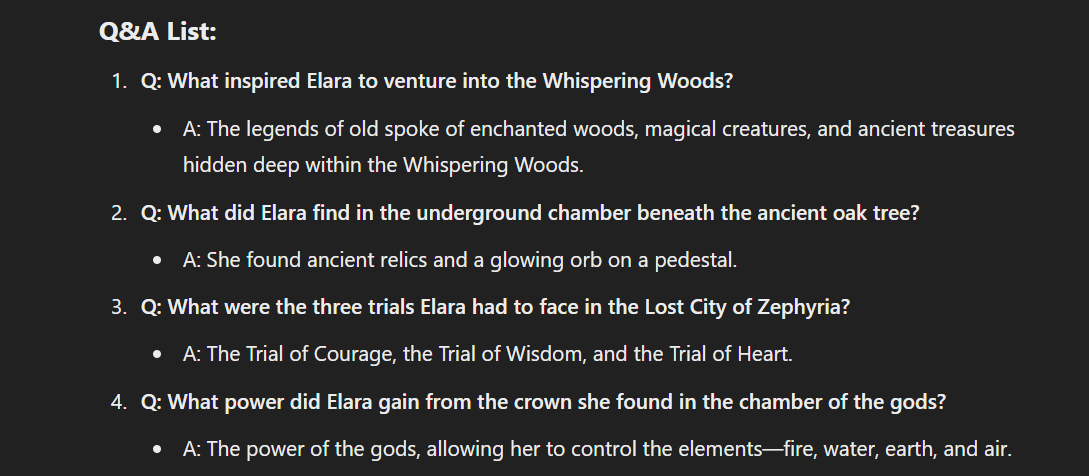